*Explanation of the Code and Algorithms*

We load two pre-trained models:

AlexNet: A deep convolutional neural network (CNN) architecture for image classification.

MobileNet: A lightweight CNN architecture for object detection.

AlexNet is used for classifying objects within bounding boxes, while MobileNet is used for detecting those objects.

*Image Preprocessing*

Images are preprocessed using the transforms module from torchvision.
The preprocessing steps include resizing, center cropping, converting to a tensor, and normalizing pixel values.

*Object Detection with MobileNet*

MobileNet is a deep learning model specifically designed for efficient object detection.
We use the pre-trained MobileNet model to detect objects in the input images.
The model predicts bounding boxes and confidence scores for detected objects.
Non-maximum suppression (NMS) is applied to filter out overlapping bounding boxes.

*Non-maximum suppression (NMS)*

NMS is a post-processing step that helps eliminate duplicate detections by selecting the most relevant bounding boxes.
By discarding redundant bounding boxes, NMS helps reduce false positives in object detection results.

*Classification with AlexNet*

For each detected object, we extract the bounding box coordinates.
The object image within the bounding box is converted to a PIL image.
The object image is preprocessed and classified using AlexNet.
The predicted label for each object is printed.

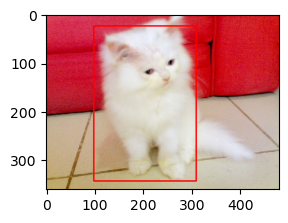

Predicted label for n02123394_1012.JPEG: 333: 'hamster',


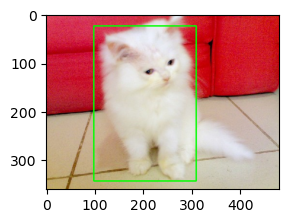

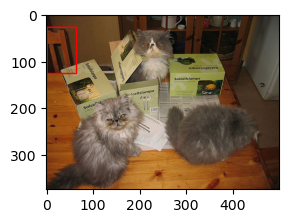

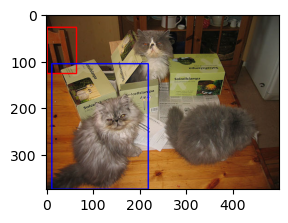

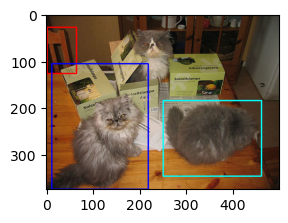

Predicted label for n02123394_5438.JPEG: 583: 'guillotine',
Predicted label for n02123394_5438.JPEG: 283: 'Persian cat',
Predicted label for n02123394_5438.JPEG: 283: 'Persian cat',


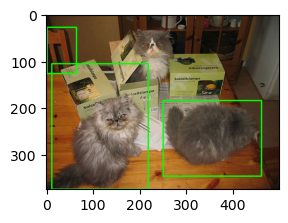

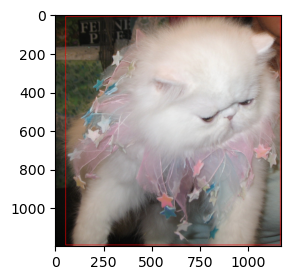

Predicted label for n02123394_4248.JPEG: 283: 'Persian cat',


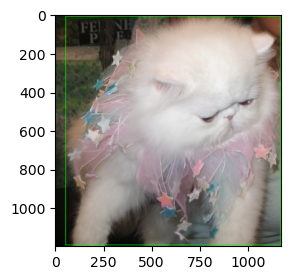

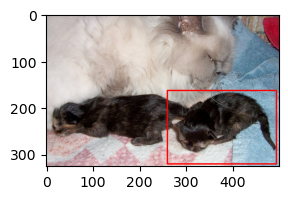

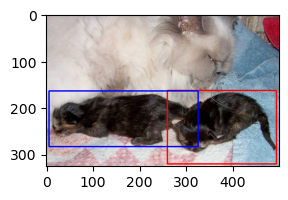

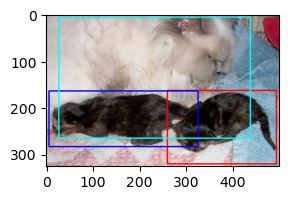

Predicted label for n02123394_2623.JPEG: 359: 'black-footed ferret, ferret, Mustela nigripes',
Predicted label for n02123394_2623.JPEG: 338: 'guinea pig, Cavia cobaya',
Predicted label for n02123394_2623.JPEG: 332: 'Angora, Angora rabbit',


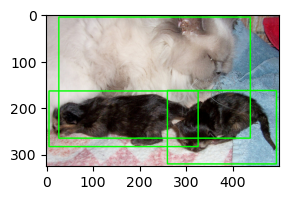

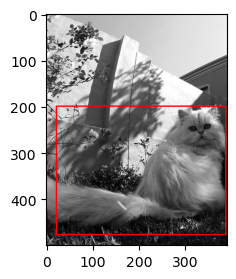

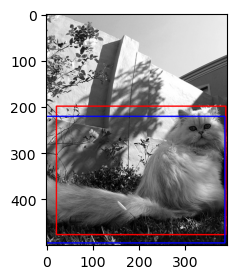

Predicted label for n02123394_2203.JPEG: 283: 'Persian cat',


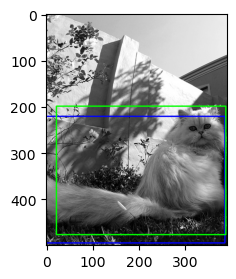

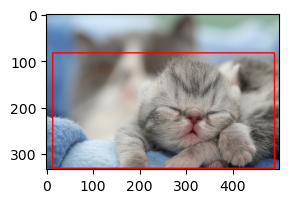

Predicted label for n02123394_2742.JPEG: 283: 'Persian cat',


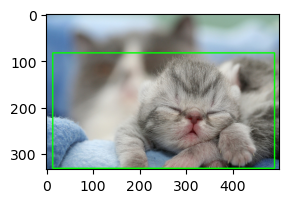

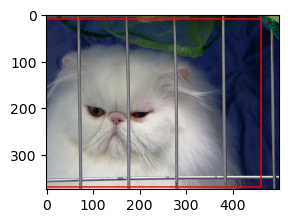

Predicted label for n02123394_2359.JPEG: 283: 'Persian cat',


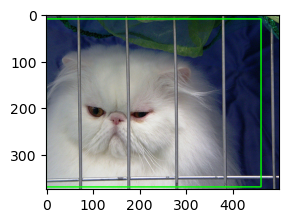

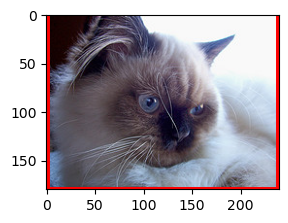

Predicted label for n02123394_1753.JPEG: 284: 'Siamese cat, Siamese',


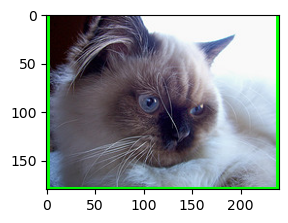

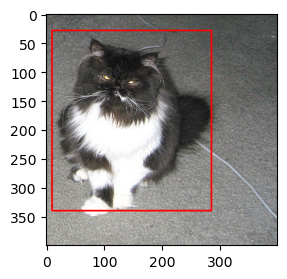

Predicted label for n02123394_1979.JPEG: 154: 'Pekinese, Pekingese, Peke',


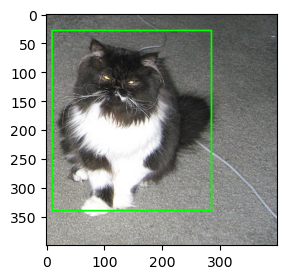

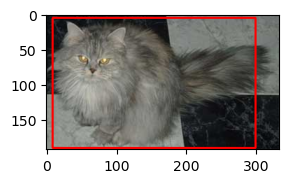

Predicted label for n02123394_7601.JPEG: 283: 'Persian cat',


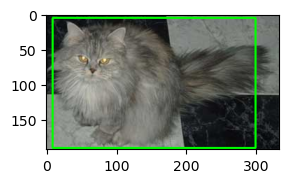

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torchvision import transforms
from torchvision import models
from PIL import Image


#pre-trained AlexNet model using torchvision
model = models.alexnet(pretrained=True)
model.eval()

# Processsing the image for object detection
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Directory of persian cat folder
img_dir = r"C:\Users\Sindhu\Downloads\n02123394"

# Getting all the file names in the directory
all_files = os.listdir(img_dir)

# Filter for jpeg (since imagenet uses jpeg)
all_images = [file for file in all_files if file.endswith('.JPEG')]

# Randomly selecting 10 images
num_images = min(10, len(all_images))
selected_images = random.sample(all_images, num_images)

# Loading the pre-trained MobileNet model for object detection
net = cv2.dnn.readNetFromCaffe(r'C:\Users\Sindhu\Downloads\deploy.prototxt', r"C:\Users\Sindhu\Downloads\mobilenet_iter_73000.caffemodel")

                        
def custom_nms(boxes, scores, iou_threshold=0.5):
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    selected_boxes = []
    while sorted_indices:
        best_idx = sorted_indices[0]
        selected_boxes.append(boxes[best_idx])
        sorted_indices = [i for i in sorted_indices if i != best_idx]
        for idx in sorted_indices:
            if iou(boxes[best_idx], boxes[idx]) > iou_threshold:
                sorted_indices.remove(idx)
    return selected_boxes

def iou(box1, box2):
    
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    # Calculate intersection area
    intersection_area = max(0, min(x2, x2_) - max(x1, x1_)) * max(0, min(y2, y2_) - max(y1, y1_))

    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

with open(r"C:\Users\Sindhu\Downloads\ImageNetClassLabels\ImageNet.txt", 'r') as f:
     labels = f.readlines()
  # Clean up labels (remove extra characters if needed)
     labels = [line.strip() for line in labels]
    
    
    
for image_file in selected_images:
    img_path = os.path.join(img_dir, image_file)
    image = cv2.imread(img_path)

   # Processsing the image for object detection
    blob = cv2.dnn.blobFromImage(image, 0.007843, (300, 300), 127.5)

    # Set the blob as input to the network and perform a forward-pass to obtain detections
    net.setInput(blob)
    detections = net.forward()

    # lists to store bounding boxes and confidences
    final_boxes = []
    confidences = []
    
    #Different colours for our identification
    colors = [(0, 0, 255),(255, 0, 0), (255, 255, 0), (128, 0, 128), (255, 165, 0), (255, 192, 203), (0, 255, 255), (139, 69, 19)]
    
    
    
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            color = colors[i % len(colors)]
            
            # Compute bounding box coordinates
            box = detections[0, 0, i, 3:7] * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
            final_boxes.append(box.astype("int"))
            confidences.append(float(confidence))

            # Draw bounding box on the image
            startX, startY, endX, endY = map(int, box)
            cv2.rectangle(image, (startX, startY), (endX, endY),color, 2)

            # Display the image
            plt.figure(figsize=(3, 3))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()
            
    selected_boxes = custom_nms(final_boxes, confidences)
    if len(selected_boxes) > 0:
                for box in selected_boxes:
                    (startX, startY, endX, endY) = box
                    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
                    object_img = image[startY:endY, startX:endX]
                    if object_img.size != 0:
                        object_img = cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB)
                        object_img = Image.fromarray(object_img)
                        input_tensor = preprocess(object_img)
                        input_batch = input_tensor.unsqueeze(0)
                        if torch.cuda.is_available():
                            input_batch = input_batch.to('cuda')
                            model.to('cuda')
                        with torch.no_grad():
                            output = model(input_batch)
            
                        _, predicted_idx = torch.max(output, 1)
                        predicted_label = labels[predicted_idx.item()]
                        print(f"Predicted label for {image_file}: {predicted_label}")
                        
                    else:
                        print(f"The image {image_file} is empty.")    
                        
                plt.figure(figsize=(3, 3))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
                plt.show() 
        
                        

